### Problem Statement:
The Air Passenger dataset provides monthly total of US airline passengers, from 1949 to 1960.
This dataset is of a time series class.

### Objective:
• Check for the stationarity of your data using Rolling Statistics and Dickey fuller test

• If stationarity is present, remove it using differencing in Python

• Perform ARIMA modeling in Python after obtaining ACF and PACF plots

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:/data/AirPassengers.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [6]:
data['Month'].head()

0    1949-01
1    1949-02
2    1949-03
3    1949-04
4    1949-05
Name: Month, dtype: object

In [7]:
#display total monthly passenger count
data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]),int(x[5:]),15))
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [8]:
#assigning passenger data time series variable
ts = data['#Passengers']

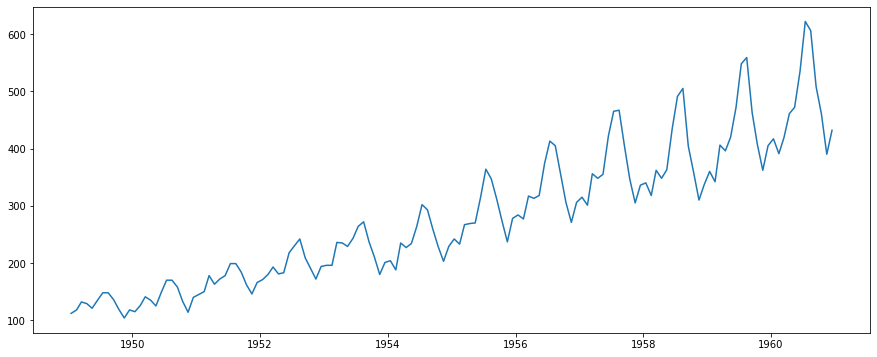

In [9]:
plt.plot(ts)

In [10]:
#transformig series using log
ts_log = np.log(ts)

In [13]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52,center=False).mean()
    rolstd = timeseries.rolling(window=52,center=False).std()
    
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rolmean,color='red',label='Rolling Mean')
    std = plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Result of Dickey-Fluller Test :')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used',
                                           'Number of Obervations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Cretical value(%s)'%key] = value
    print(dfoutput)

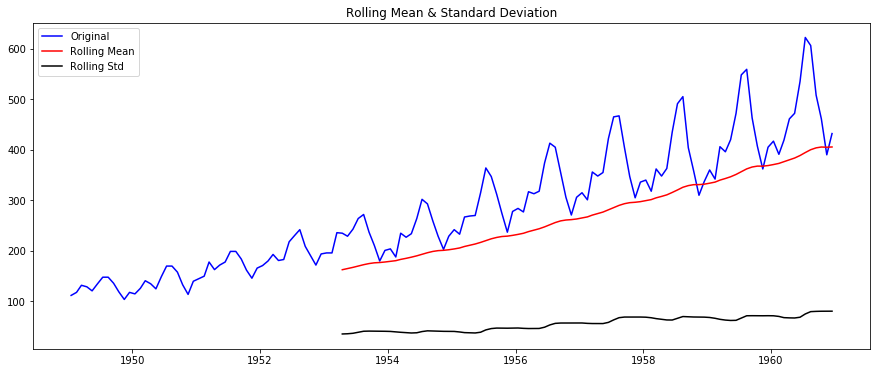

Result of Dickey-Fluller Test :
Test Statistic                  0.815369
p-value                         0.991880
#Lags Used                     13.000000
Number of Obervations Used    130.000000
Cretical value(1%)             -3.481682
Cretical value(5%)             -2.884042
Cretical value(10%)            -2.578770
dtype: float64


In [14]:
test_stationarity(data['#Passengers'])

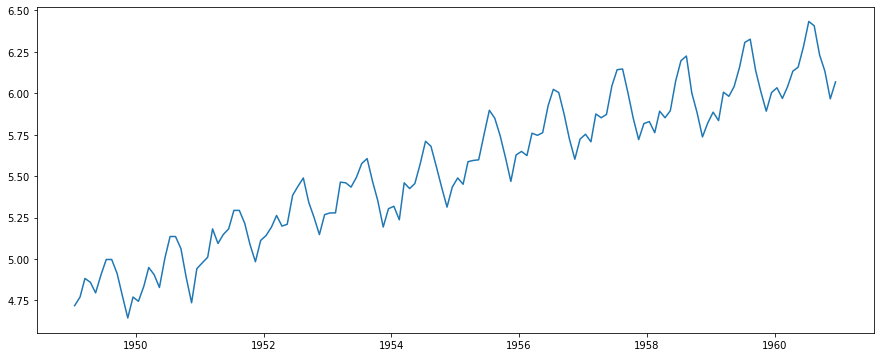

In [15]:
plt.plot(ts_log)

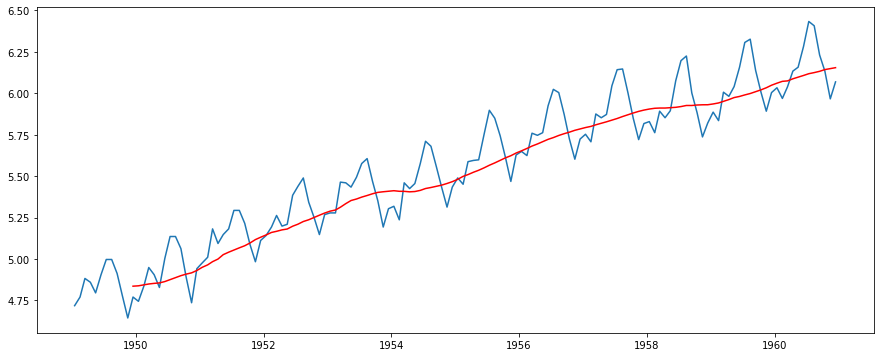

In [17]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [18]:
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)

ts_log_mv_diff.dropna(inplace= True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

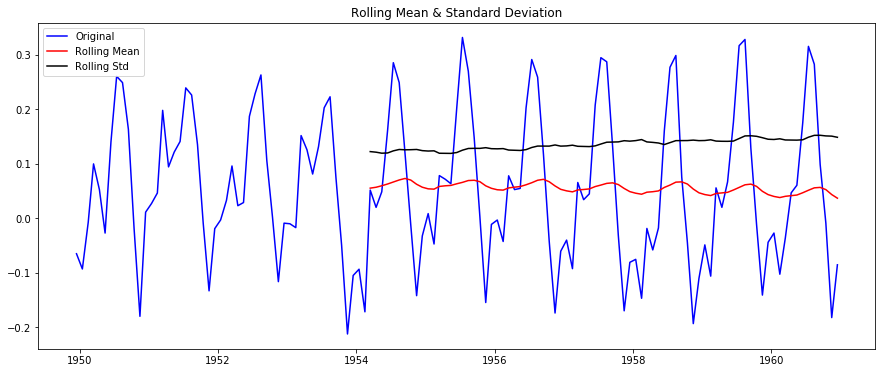

Result of Dickey-Fluller Test :
Test Statistic                 -3.162908
p-value                         0.022235
#Lags Used                     13.000000
Number of Obervations Used    119.000000
Cretical value(1%)             -3.486535
Cretical value(5%)             -2.886151
Cretical value(10%)            -2.579896
dtype: float64


In [19]:
test_stationarity(ts_log_mv_diff)

In [20]:
#we can reject null hypothesis

##### Fit a model using an ARIMA algorithm
###### Calculate forecasts
##### to find out the p and q values for the model,we will use ACF and PACF plots

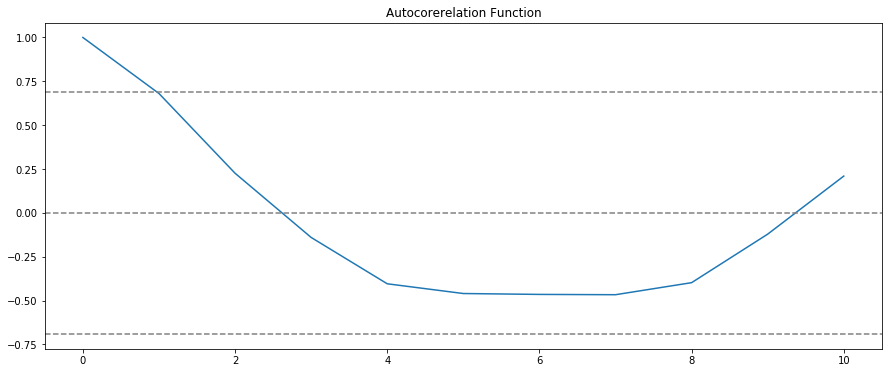

In [22]:
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorerelation Function')
plt.show()

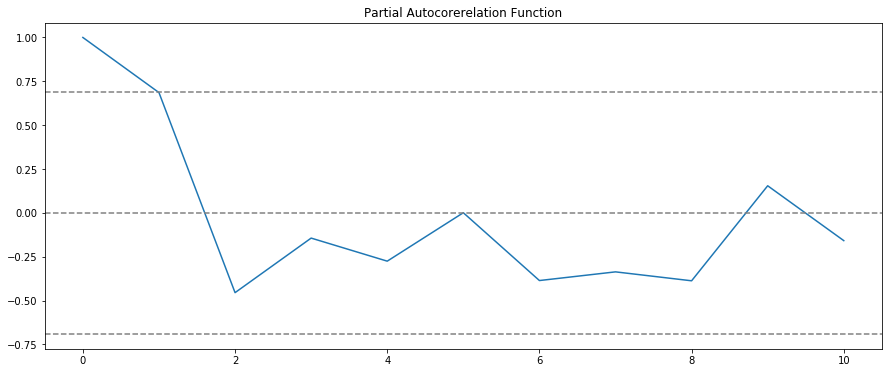

In [23]:
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorerelation Function')
plt.show()

Text(0.5, 1.0, 'RSS: nan')

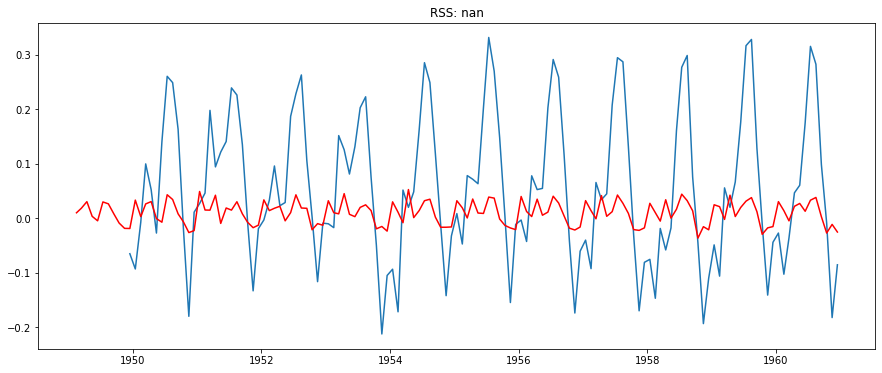

In [24]:
model  = ARIMA(ts_log,order=(1,1,0))
result_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(result_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((result_ARIMA.fittedvalues[1:]) -ts_log_mv_diff)**2)

In [27]:
predictions_Arima_diff = pd.Series(result_ARIMA.fittedvalues,copy=True)
predictions_Arima_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [29]:
predictions_Arima_diff_cumsum = predictions_Arima_diff.cumsum()
predictions_Arima_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [33]:
predictions_Arima_log = pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_Arima_log = predictions_Arima_log.add(predictions_Arima_diff_cumsum,fill_value=0)
predictions_Arima_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

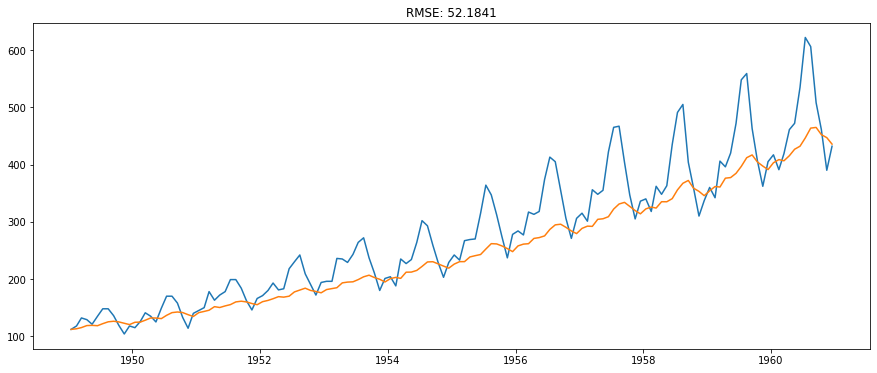

In [40]:
predictions_Arima = np.exp(predictions_Arima_log)
plt.plot(ts)
plt.plot(predictions_Arima)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_Arima-ts)**2)/len(ts)))